# Classifying Country Music Lyrics

# Purpose: 
<h4 style="margin-bottom: 1;"> I analyzed Country music lyrics to uncover the genre's core themes through applying natural language techniques and diving into the stories that resonate with so many listeners. </h4>

![Alt text](Images/ProjectScope.png)

# Featured Songs
## [Playlist: Click Here to Access via Spotify](https://open.spotify.com/playlist/6wS1RaOrTQiwlNTOuFyJcx?si=686ab2a0fa4444f0)

![Alt text](Images/Playlist_A.png)

![Alt text](Images/Playlist_B.png)

![Alt text](Images/Playlist_C.png)

## Initial Setup

In [1]:
# Import Required Libraries
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import pandas as pd
import numpy as np
import warnings
import random
import nltk
import ast
import re

# Import Specific Functions
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from tabulate import tabulate
from PIL import Image

# Ignore All Warnings 
warnings.filterwarnings("ignore")

# Download NLTK Files Only If They Haven't Been Downloaded Already
nltk.download('stopwords', quiet=True)

# Load Song Lyrics
song_lyrics = pd.read_excel('Data/song_lyrics.xlsx')
song_lyrics['Artists'] = song_lyrics['Artists'].apply(ast.literal_eval)
song_lyrics['Hometowns'] = song_lyrics['Hometowns'].apply(ast.literal_eval)

# Data Exploration

### Preprocess Song Lyrics

In [2]:
# Define Function to Preprocess Lyrics
def preprocess_lyrics(lyrics):
    stop_words = set(stopwords.words('english'))    
    
    # Process lyrics: clean and tokenize
    tokens = nltk.word_tokenize(re.sub(r'[^a-zA-Z\s]', '', lyrics.lower()))
    return tokens

# Apply Pre-Processing to the Lyrics Column
song_lyrics['Processed_Lyrics'] = song_lyrics['Lyrics'].apply(preprocess_lyrics)

# Define a function to merge specific patterns in Processed_Lyrics
def merge_tokens(tokens):
    corrected_tokens = []
    skip_next = False

    for i in range(len(tokens) - 1):
        if skip_next:
            skip_next = False
            continue

        # Merge patterns like "wan na" -> "wanna"
        if tokens[i] == 'wan' and tokens[i + 1] == 'na':
            corrected_tokens.append('wanna')
            skip_next = True
        elif tokens[i] == 'gon' and tokens[i + 1] == 'na':
            corrected_tokens.append('gonna')
            skip_next = True
        elif tokens[i] == 'got' and tokens[i + 1] == 'ta':
            corrected_tokens.append('gotta')
            skip_next = True
        else:
            corrected_tokens.append(tokens[i])

    # Add the last token if it wasn't part of a pair
    if not skip_next and len(tokens) > 0:
        corrected_tokens.append(tokens[-1])

    return corrected_tokens

# Apply the correction step to the Processed_Lyrics column
song_lyrics['Processed_Lyrics'] = song_lyrics['Processed_Lyrics'].apply(merge_tokens)

# Convert Processed Lyrics Back to String Form for Analysis
song_lyrics['Processed_Text'] = song_lyrics['Processed_Lyrics'].apply(lambda x: ' '.join(x))

# Preview the DataFrame
song_lyrics.head()

,Song_Title,Release_Date,Artists,Hometowns,Lyrics,Processed_Lyrics,Processed_Text
0,Oklahoma Smokeshow,2022-07-15,[Zach Bryan],"[Oologah, Oklahoma]",Go on and put on that dress that all the bad b...,"[go, on, and, put, on, that, dress, that, all,...",go on and put on that dress that all the bad b...
1,Heading South,2019-09-30,[Zach Bryan],"[Oologah, Oklahoma]","Was a boy who was a dreamer, and he flew so hi...","[was, a, boy, who, was, a, dreamer, and, he, f...",was a boy who was a dreamer and he flew so hig...
2,Revival,2020-05-08,[Zach Bryan],"[Oologah, Oklahoma]","Gather 'round this table, boys\nBring your sha...","[gather, round, this, table, boys, bring, your...",gather round this table boys bring your shame ...
3,Nine Ball,2023-09-22,[Zach Bryan],"[Oologah, Oklahoma]","I don't wanna bet, but my father wrote a check...","[i, dont, wanna, bet, but, my, father, wrote, ...",i dont wanna bet but my father wrote a check t...
4,From Austin,2022-02-25,[Zach Bryan],"[Oologah, Oklahoma]",There is concrete below me and a sky above so ...,"[there, is, concrete, below, me, and, a, sky, ...",there is concrete below me and a sky above so ...


In [3]:
# This function is designed to identify and analyze the original context in which words appear within song lyrics
def initial_lyrics_analysis(lyrics_word_search, output_filename="Initial_Lyrics_Analysis.xlsx"):
    song_details = []

    # Extract all words from Processed_Lyrics and create a set of unique words 
    all_processed_words = [word for lyrics in lyrics_word_search['Processed_Lyrics'] for word in lyrics]
    unique_words = set(all_processed_words)

    # Iterate through each word to find word occurrences in Lyrics
    for word in unique_words:
        # Iterate through each song in the dataset
        for index, row in lyrics_word_search.iterrows():
            lyrics = row['Lyrics']  # Original lyrics
            processed_text = row['Processed_Text']  # Punctuation-removed processed text

            # Count word occurrences in Processed_Text
            word_count_in_processed = processed_text.lower().split().count(word.lower())

            # If the word is found in Processed_Text, extract its context
            if word_count_in_processed > 0:
                # Split the original Lyrics into lines for detailed context
                original_lines = lyrics.split('\n')

                # Enumerate through lines to retain their order
                for line_number, original_line in enumerate(original_lines, start=1):
                    
                    # Process the line by removing punctuation and convert to lowercase
                    processed_line = re.sub(r'[^a-zA-Z\s]', '', original_line).lower()

                    # Check if the word is present in the processed line
                    matches = re.findall(rf'\b{re.escape(word)}\b', processed_line, flags=re.IGNORECASE)

                    if matches:
                        # Extract the list of artists for the song
                        artist_list = row['Artists']
                        hometown_list = row['Hometowns']

                        # Append the extracted details
                        song_details.append({
                            'Song_Title': row['Song_Title'],
                            'Release_Date': row['Release_Date'],
                            'Artists': artist_list,
                            'Hometowns': hometown_list,
                            'Word': word,
                            'Line_Number': line_number,
                            'Original_Line': original_line.strip(),
                            'Classification': "",  # Placeholder for Categorization
                            'Cnt_of_Word': len(matches)
                        })

    # Convert results to a DataFrame
    song_details_df = pd.DataFrame(song_details)

    # Sort by Song Title and Line Number
    song_details_df = song_details_df.sort_values(by=['Song_Title', 'Line_Number', 'Word']).reset_index(drop=True)

    # Save to Excel
    song_details_df.to_excel(output_filename, index=False)

    # Return Results as a DataFrame
    return song_details_df

# Call the function
song_details_df = initial_lyrics_analysis(song_lyrics)
song_details_df.head()

,Song_Title,Release_Date,Artists,Hometowns,Word,Line_Number,Original_Line,Classification,Cnt_of_Word
0,"1, 2 Many",2019-08-23,"[Brooks & Dunn, Luke Combs]","[Nashville, Tennessee, Huntersville, North Car...",a,1,"A one, two",,1
1,"1, 2 Many",2019-08-23,"[Brooks & Dunn, Luke Combs]","[Nashville, Tennessee, Huntersville, North Car...",one,1,"A one, two",,1
2,"1, 2 Many",2019-08-23,"[Brooks & Dunn, Luke Combs]","[Nashville, Tennessee, Huntersville, North Car...",two,1,"A one, two",,1
3,"1, 2 Many",2019-08-23,"[Brooks & Dunn, Luke Combs]","[Nashville, Tennessee, Huntersville, North Car...",a,2,"Well, I got a call from Rowdy 'round six o'clock",,1
4,"1, 2 Many",2019-08-23,"[Brooks & Dunn, Luke Combs]","[Nashville, Tennessee, Huntersville, North Car...",call,2,"Well, I got a call from Rowdy 'round six o'clock",,1


### Extract Individual Artists that Worked on a Song

In [4]:
def get_artist_details(song_details_df):
    # Create a list of (artist, hometown, song_title) to ensure accurate counts
    artist_hometown_song_pairs = [
        (artist, hometown, row['Song_Title'])
        for _, row in song_details_df.iterrows()
        for artist, hometown in zip(row['Artists'], row['Hometowns'])
    ]

    # Convert to DataFrame
    artist_hometown_df = pd.DataFrame(
        artist_hometown_song_pairs, columns=['Artist', 'Hometown', 'Song_Title']
    )

    # Count the number of unique songs for each artist
    artist_data = (
        artist_hometown_df.groupby(['Artist', 'Hometown'])['Song_Title']
        .nunique()  # Count unique songs
        .reset_index(name='Number of Songs in Playlist')
        .sort_values(by='Number of Songs in Playlist', ascending=False)
        .reset_index(drop=True)
    )

    return artist_data

# Display top 13 artists who have more than 5 songs featured
artist_details = get_artist_details(song_details_df)
artist_details.head(13)

,Artist,Hometown,Number of Songs in Playlist
0,Willie Nelson,"Abbott, Texas",9
1,Luke Combs,"Huntersville, North Carolina",8
2,Johnny Cash,"Kingsland, Arkansas",7
3,Post Malone,"Syracuse, New York",7
4,Waylon Jennings,"Littlefield, Texas",7
5,Tyler Childers,"Lawrence County, Kentucky",6
6,Dolly Parton,"Sevierville, Tennessee",6
7,Hank Williams Jr.,"Shreveport, Louisiana",6
8,Billy Strings,"Lansing, Michigan",6
9,Zach Bryan,"Oologah, Oklahoma",6


### Number of Songs by Top Featured Artists Visual

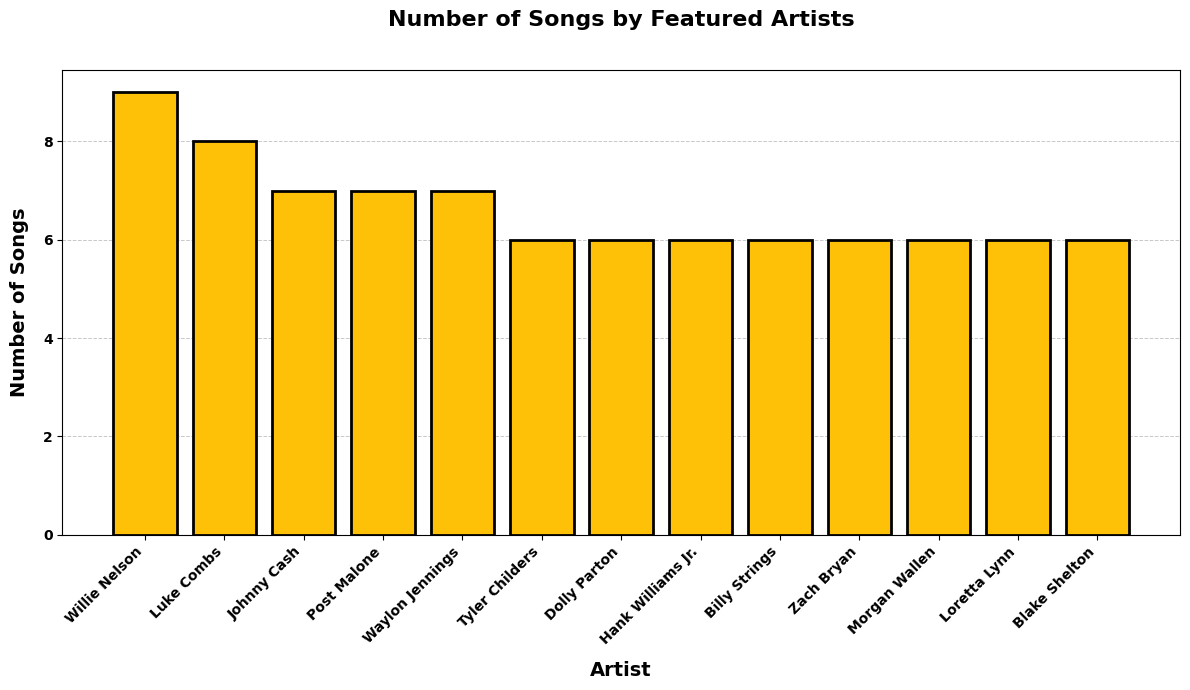

In [5]:
# Sort data to display the top artists
artist_data_sorted = artist_details.sort_values(by='Number of Songs in Playlist', ascending=False).head(13)

# Create the bar plot
plt.figure(figsize=(12, 7))
plt.bar(
    artist_data_sorted['Artist'],
    artist_data_sorted['Number of Songs in Playlist'],
    color='#FFC107',
    edgecolor='black',
    linewidth=2
)

# Add title and labels
plt.title('Number of Songs by Featured Artists\n', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Artist', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('Number of Songs', fontsize=14, labelpad=10, fontweight='bold')

# Customize ticks
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Add gridlines and ensure they are behind bars
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

# Optimize layout and display
plt.tight_layout()
plt.show()

### Geocode Artist Hometowns and Visualize Collaborations

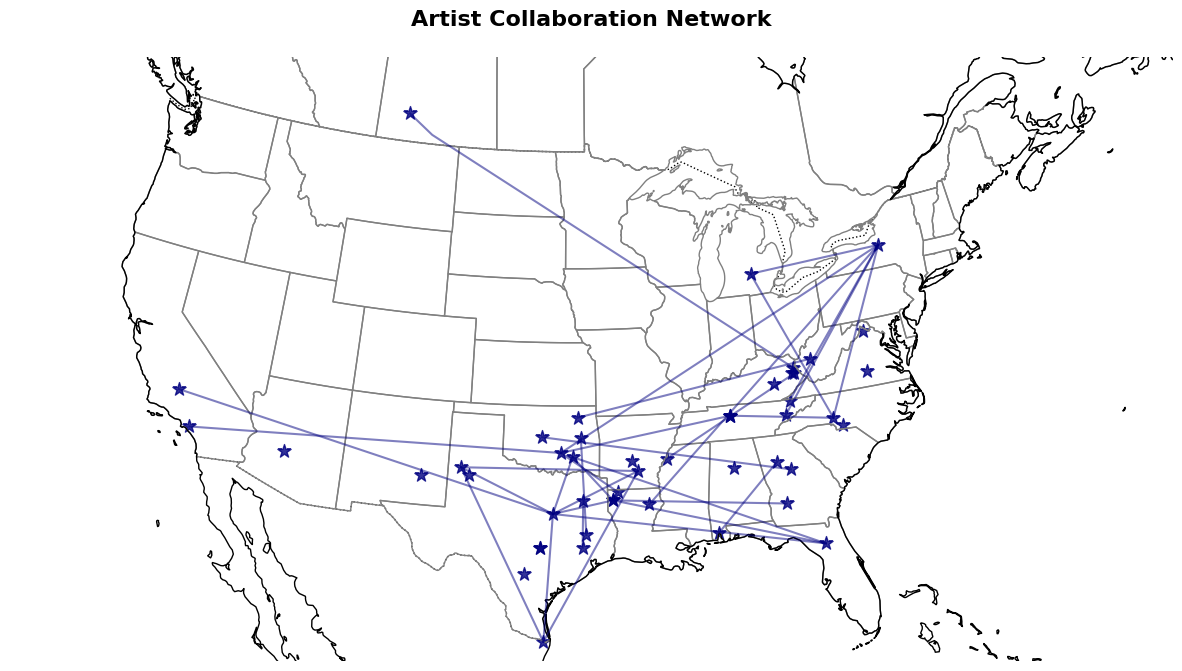

In [6]:
# Geocode Artist Hometown
geolocator = Nominatim(user_agent="artist_map")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Add latitude and longitude to artist_details
artist_details['Location'] = artist_details['Hometown'].apply(geocode)
artist_details['Latitude'] = artist_details['Location'].apply(lambda loc: loc.latitude if loc else None)
artist_details['Longitude'] = artist_details['Location'].apply(lambda loc: loc.longitude if loc else None)

# Create a graph for artist collaboration
G = nx.Graph()

# Add nodes for each artist with latitude and longitude as attributes
for _, row in artist_details.iterrows():
    G.add_node(row['Artist'], pos=(row['Longitude'], row['Latitude']), hometown=row['Hometown'])

collaboration_data = set()

# Add edges for collaborations
for _, row in song_details_df.drop_duplicates(subset=['Song_Title']).iterrows():
    artists = row['Artists']
    if len(artists) > 1:
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                if G.has_node(artists[i]) and G.has_node(artists[j]):
                    G.add_edge(artists[i], artists[j])
                    collaboration_data.add(row['Song_Title'])

# Get the number of plotted artists
plotted_artists = {artist for artist, data in G.nodes(data=True) if data['pos'][0] and data['pos'][1]}

# Get the number of artists with at least one collaboration
artists_with_collab = set([node for edge in G.edges() for node in edge])

# Set up Cartopy map with Lambert Conformal projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.LambertConformal()})
ax.set_extent([-125, -65, 25, 50], crs=ccrs.PlateCarree())  # Zoom into central/eastern US

# Add country, state, and coastline boundaries
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="black")
ax.add_feature(cfeature.STATES, edgecolor="gray")  # Add U.S. state boundaries
ax.add_feature(cfeature.COASTLINE)

# Get positions for nodes from the graph
pos = {artist: (data['pos'][0], data['pos'][1]) for artist, data in G.nodes(data=True) if data['pos'][0] and data['pos'][1]}

# Plot nodes as points on the map
for artist, (lon, lat) in pos.items():
    ax.scatter(lon, lat, transform=ccrs.PlateCarree(), color='#000080', marker='*', s=100, alpha=0.8)

# Draw edges (collaborations) as lines on the map
for u, v in G.edges():
    if u in pos and v in pos:
        x = [pos[u][0], pos[v][0]]
        y = [pos[u][1], pos[v][1]]
        ax.plot(x, y, transform=ccrs.PlateCarree(), color='#000080', alpha=0.5)

plt.title("Artist Collaboration Network\n", fontsize=16, fontweight="bold")
plt.axis("off")
plt.show()

### Number of Collaborations between Artists

In [7]:
# Print the total number of collaborations
print(f"Total number of plotted artists: {len(plotted_artists)}")
print(f"Total number of collaborations: {len(collaboration_data)}")
print(f"Total number of artists with at least one collaboration: {len(artists_with_collab)}")

Total number of plotted artists: 50
Total number of collaborations: 26
Total number of artists with at least one collaboration: 35


### Artist Collaborations

![Alt text](Images/Collabs_A.png)

![Alt text](Images/Collaborations_B.png)

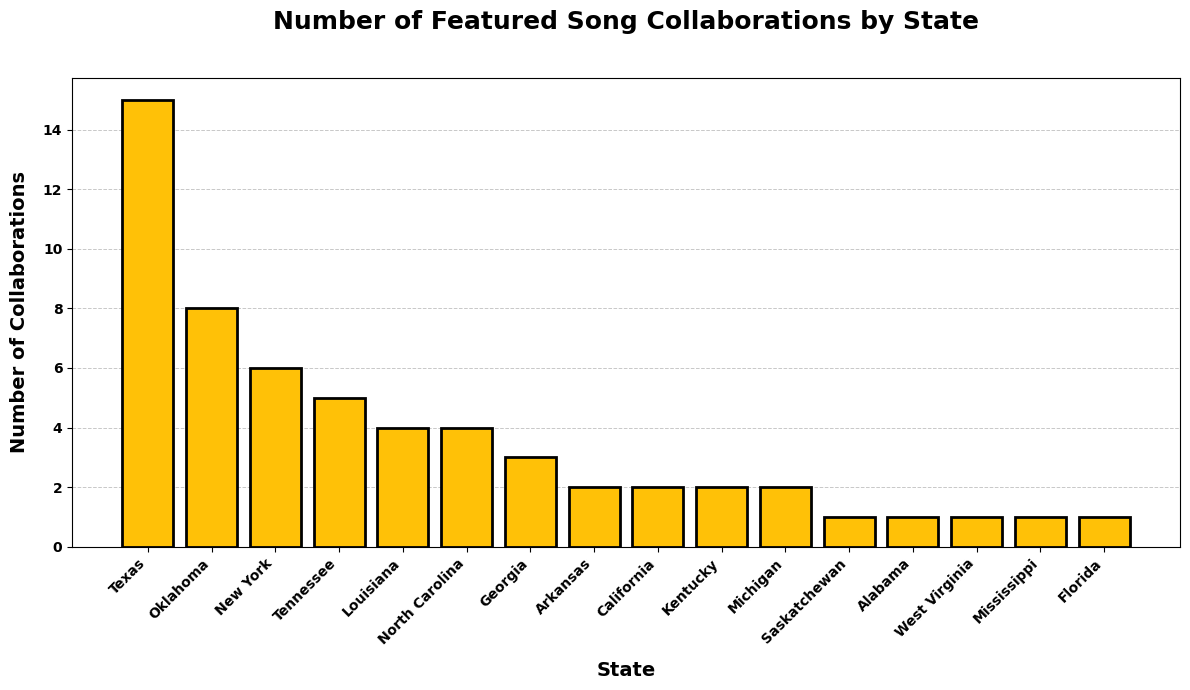

In [8]:
# Filter rows where Song_Title is in collaboration_data and select specific columns
filtered_df = song_details_df[song_details_df['Song_Title'].isin(collaboration_data)][['Song_Title', 'Hometowns']]

# Convert Hometowns lists to tuples in the filtered DataFrame to allow dropping duplicates
filtered_df['Hometowns'] = filtered_df['Hometowns'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Drop duplicates based on Song_Title and Hometowns
filtered_df = filtered_df.drop_duplicates()

# Initialize a dictionary to count collaborations by state
state_collaborations = {}

# Process each row in filtered_df to calculate collaborations by state
for _, row in filtered_df.iterrows():
    if isinstance(row['Hometowns'], tuple):  # Ensure Hometowns is a tuple
        # Extract states for all artists in the collaboration
        states = [hometown.split(', ')[-1] for hometown in row['Hometowns'] if ', ' in hometown]
        
        # Count each state based on the number of artists from that state
        for state in states:
            state_collaborations[state] = state_collaborations.get(state, 0) + 1

# Convert the state_collaborations dictionary into a Series for plotting
state_counts = pd.Series(state_collaborations).sort_values(ascending=False)

# Create the bar graph
plt.figure(figsize=(12, 7))
plt.bar(state_counts.index, state_counts.values, color='#FFC107', edgecolor='black', linewidth=2, width=0.8)

# Add title and labels
plt.title('Number of Featured Song Collaborations by State\n', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('State', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('Number of Collaborations', fontsize=14, labelpad=10, fontweight='bold')

# Customize ticks with bold font
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Add gridlines and ensure they're behind bars
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

# Optimize layout and display
plt.tight_layout()
plt.show()

### Song Releases Over Time

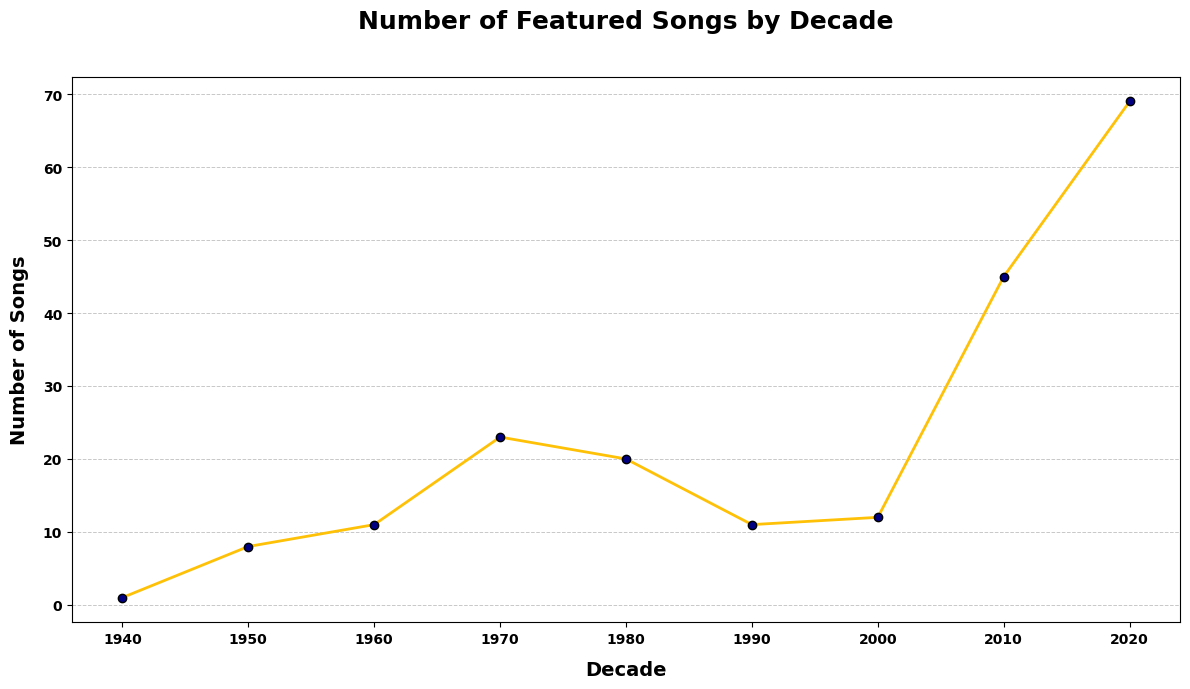

In [9]:
# Remove duplicates based on 'Song_Title'
unique_songs_df = song_details_df.drop_duplicates(subset=['Song_Title'])

# Group by decade and count the number of unique songs
unique_songs_df['Decade'] = (unique_songs_df['Release_Date'].dt.year // 10) * 10
songs_by_decade = unique_songs_df['Decade'].value_counts().sort_index()

# Create the line graph
plt.figure(figsize=(12, 7))
plt.plot(songs_by_decade.index, songs_by_decade.values, color='#FFC107', linewidth=2, marker='o', 
         markerfacecolor='#000080', markeredgecolor='black', markersize=6)

# Add title and labels
plt.title('Number of Featured Songs by Decade\n', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Decade', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Songs', fontsize=14, fontweight='bold', labelpad=10)

# Customize x-ticks (decades from 1940's to 2020's)
plt.xticks(range(1940, 2030, 10), fontsize=10, fontweight='bold')

# Customize y-ticks
plt.yticks(fontsize=10, fontweight='bold')

# Add gridlines
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

# Display the plot
plt.tight_layout()
plt.show()

### Generate a Wordcloud to Find Frequently Mentioned Words

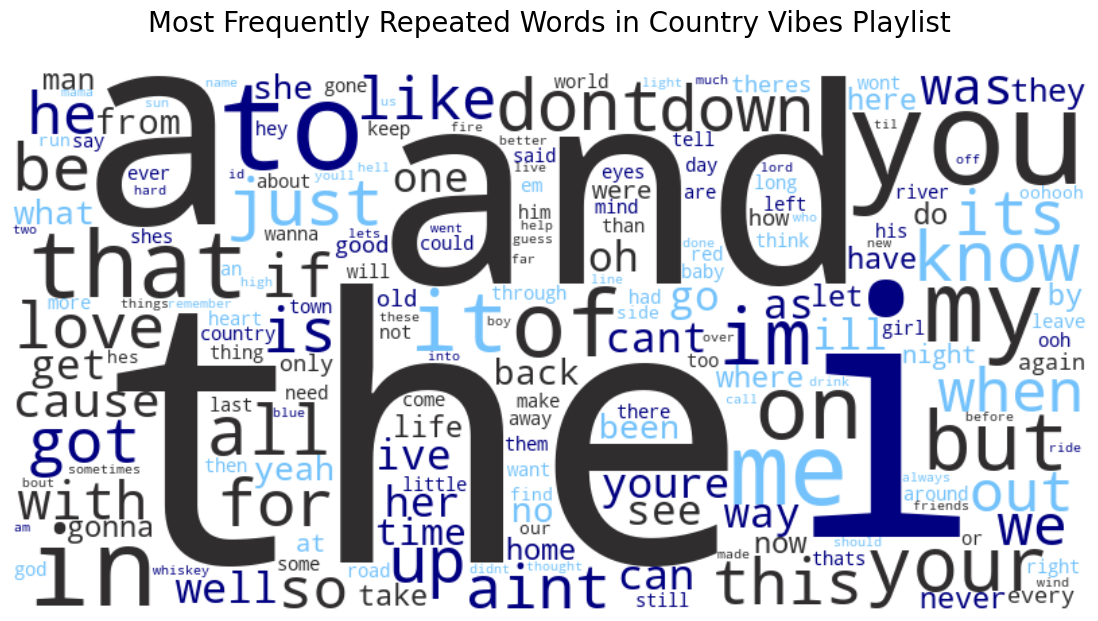

In [10]:
# Aggregate Word Counts from song_details_df
word_counts = song_details_df.groupby('Word')['Cnt_of_Word'].sum().to_dict()

# Define the color palette
primary_color = '#000080'
complementary_colors = ['#73C2FB', '#2F2D2E']

# Custom color function to use the specified colors
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = [primary_color] + complementary_colors
    return random.choice(colors)

# Generate Word Cloud with custom colors using the word frequencies
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=custom_color_func,
    prefer_horizontal=1.0,
    random_state=42,
    max_words=200
).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequently Repeated Words in Country Vibes Playlist\n", fontsize=20)
plt.show()

## Classifying Country

![Alt text](Images/Topic_Modeling_Themes.png)

### Stay Tuned